# Timm使用教程
timm（Pytorch Image Models）项目是一个图像分类模型库，通过timm可以轻松的搭建出各种sota模型（目前内置预训练模型592个，包含densenet系列、efficientnet系列、resnet系列、vit系列、vgg系列、inception系列、mobilenet系列、xcit系列等等），并进行迁移学习。

下面详细介绍timm的基本用法和高级用法
- 基本用法:指用timm实现出迁移学习模型，构造出知识蒸馏模型；
- 高级用法:指使用timm的内置模块实现自己的网络，及对timm内置模型的修改和微调。
- 此外，timm的作者在官网实现了timm内置模型的train、validate、inference

官方指导链接：https://huggingface.co/docs/timm/quickstart#quickstart

本文档的配套使用教程：【推荐！！！】
https://www.bilibili.com/video/BV1bT42167nw/?vd_source=6e452cd7908a2d9b382932f345476fd1 

# 1.安装timm

In [1]:
# !pip install timm

# 2.加载预训练模型

In [3]:
import timm

m = timm.create_model('mobilenetv3_large_100', 
                      pretrained=True,   # 需要开启internet按钮
                      #in_chans=1         # 可以处理非3通道的数据，只需要指定通道数即可
                     ) 
model = m.cuda()     #需要调用GPU（开启）

In [4]:
m.eval()   #查看模型结构

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
     

## 2.1 .手动加载对应模型权重

In [5]:
import timm
# 查看模型cfg，得到模型对应的网址
model = timm.create_model('resnet18')#pretrained=True,
print(model.default_cfg)#查看模型cfg

{'url': 'https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet18_a1_0-d63eafa0.pth', 'hf_hub_id': 'timm/resnet18.a1_in1k', 'architecture': 'resnet18', 'tag': 'a1_in1k', 'custom_load': False, 'input_size': (3, 224, 224), 'test_input_size': (3, 288, 288), 'fixed_input_size': False, 'interpolation': 'bicubic', 'crop_pct': 0.95, 'test_crop_pct': 1.0, 'crop_mode': 'center', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'num_classes': 1000, 'pool_size': (7, 7), 'first_conv': 'conv1', 'classifier': 'fc', 'origin_url': 'https://github.com/huggingface/pytorch-image-models', 'paper_ids': 'arXiv:2110.00476'}


In [ ]:
# 手动下载预训练模型
pre_path = '/kaggle/input/resnet18/resnet18_a1_0-d63eafa0.pth'
model = timm.create_model('resnet18', pretrained=True, 
                          #num_classes=2,    # 调整最后一层的分类个数
                          pretrained_cfg_overlay=dict(file=pre_path))  # ----模型预训练权重.pth地址

In [ ]:
# 查看模型输出效果
import torch
x = torch.randn(1,3,224,224)
output = model(x)
output.shape

## 2.2 计算模型参数量

In [7]:
!pip install thop

In [8]:
import timm
model = timm.create_model('resnest14d', pretrained=True, num_classes=2)

# 计算模型参数量
from thop import profile
import torch

input = torch.randn(1, 3, 224, 224)    # 随机输入
flops, params = profile(model, inputs=(input, ))    #计算量，参数量
print(flops, params) #计算量，参数量

model.safetensors:   0%|          | 0.00/42.6M [00:00<?, ?B/s]

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
2777295232.0 8566786.0


In [9]:
# 转换为M
total_megabytes = params / (1024 * 1024)
print("Total parameters in MB:", total_megabytes)

Total parameters in MB: 8.169923782348633


In [10]:
print(f"FLOPs: {flops / 1e9} G")  # 打印计算量（以十亿次浮点运算为单位）  
print(f"Params: {params / 1e6} M")  # 打印参数量（以百万为单位）

FLOPs: 2.777295232 G
Params: 8.566786 M


# 3.查看模型列表

In [12]:
import timm
from pprint import pprint
#model_names = timm.list_models(pretrained=True)   # 所有有预训练权重的模型
# 根据模型名称进行过滤，查看有哪些模型
model_names = timm.list_models('*resne*t*')
pprint(model_names[:10])   # 回车输出

['bat_resnext26ts',
 'cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'cspresnext50',
 'eca_resnet33ts',
 'eca_resnext26ts',
 'ecaresnet26t',
 'ecaresnet50d',
 'ecaresnet50d_pruned']


In [14]:
import timm
from pprint import pprint
# 根据模型名称进行过滤
model_names = timm.list_models('*in1k')
pprint(model_names[:10])   # 回车输出

[]


# 4.模型微调最后一层

In [16]:
NUM_FINETUNE_CLASSES = 2   # 设置分类类别数
model = timm.create_model('mobilenetv3_large_100', pretrained=True, 
                          num_classes=NUM_FINETUNE_CLASSES)   # 设置num_classes即可改变最后输出结果

In [17]:
model.classifier     # 查看最后一层的分类器

Linear(in_features=1280, out_features=2, bias=True)

# 5.特征提取

用于迁移学习

In [18]:
import timm
import torch
x = torch.randn(1, 3, 224, 224)
model = timm.create_model('mobilenetv3_large_100', pretrained=True)
features = model.forward_features(x)
print(features.shape) # 即倒数第二层，在经过最后全连接层之前

torch.Size([1, 960, 7, 7])


In [20]:
# 获取倒数第二层，线性层的特征: 如：512*1
import torch.nn as nn
model.fc = nn.Identity()    # 修改线性层为单位映射 y=x

## 可视化网络结构

参考：https://datawhalechina.github.io/thorough-pytorch/%E7%AC%AC%E4%B8%83%E7%AB%A0/7.1%20%E5%8F%AF%E8%A7%86%E5%8C%96%E7%BD%91%E7%BB%9C%E7%BB%93%E6%9E%84.html

torchvision --- summary(model)

In [21]:
import torchvision.models as models
from torchinfo import summary
summary(model, (1, 3, 224, 224)) # 模型， 输入

Layer (type:depth-idx)                        Output Shape              Param #
MobileNetV3                                   [1, 1000]                 --
├─Conv2d: 1-1                                 [1, 16, 112, 112]         432
├─BatchNormAct2d: 1-2                         [1, 16, 112, 112]         32
│    └─Identity: 2-1                          [1, 16, 112, 112]         --
│    └─Hardswish: 2-2                         [1, 16, 112, 112]         --
├─Sequential: 1-3                             [1, 960, 7, 7]            --
│    └─Sequential: 2-3                        [1, 16, 112, 112]         --
│    │    └─DepthwiseSeparableConv: 3-1       [1, 16, 112, 112]         464
│    └─Sequential: 2-4                        [1, 24, 56, 56]           --
│    │    └─InvertedResidual: 3-2             [1, 24, 56, 56]           3,440
│    │    └─InvertedResidual: 3-3             [1, 24, 56, 56]           4,440
│    └─Sequential: 2-5                        [1, 40, 28, 28]           --
│    │    └─

## 可视化模型结构（使用模型权重）

当我们有模型权重文件（*.pth）后，我们可以使用 netron 来可视化模型结构，更加直观。

netron 网址为：https://netron.app/

resnet18的网络结构

# 6.查看/设定模型的图像增强方法

In [22]:
# 查看预训练模型的相关配置（全部）
model.pretrained_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/mobilenetv3_large_100_ra-f55367f5.pth',
 'hf_hub_id': 'timm/mobilenetv3_large_100.ra_in1k',
 'architecture': 'mobilenetv3_large_100',
 'tag': 'ra_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.875,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv_stem',
 'classifier': 'classifier'}

In [23]:
# 仅解析与数据相关的配置
timm.data.resolve_data_config(model.pretrained_cfg)
# 'crop_mode': 'center' 中心裁剪
# 'crop_pct'裁剪的比例为 0.875

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.875,
 'crop_mode': 'center'}

***将其转化为Compose形式***

-- timm.data.create_transform

In [24]:
# 定义该模型的数据转换方法，用于新数据
data_cfg = timm.data.resolve_data_config(model.pretrained_cfg)    # 保存数据配置方法
transform = timm.data.create_transform(**data_cfg)   # 创建转换方法，类似 transforms.Compose
transform
#1.将图像大小调整为 256x256 像素，使用双三次插值（bicubic）进行插值操作
#2.对调整大小后的图像进行中心裁剪，裁剪尺寸为 (224, 224)

Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

# 7.使用预训练模型进行推断

## （1）待预测的图片

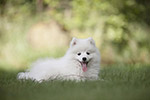

In [25]:
import requests
from PIL import Image
from io import BytesIO
#url = 'https://datasets-server.huggingface.co/assets/imagenet-1k/--/default/test/12/image/image.jpg'
url = 'http://img.sccnn.com/simg/340/03378.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

## （2）加载训练好的模型，获取数据预处理方法

In [26]:
# 加载模型，开启eval模式（不参与训练）
model = timm.create_model('mobilenetv3_large_100', pretrained=True).eval()
# 模型的数据预处理方法
transform = timm.data.create_transform(
    **timm.data.resolve_data_config(model.pretrained_cfg)
)

In [27]:
# 对图片进行数据预处理
image_tensor = transform(image)
image_tensor.shape

torch.Size([3, 224, 224])

## （3）调用模型预测

In [28]:
# 输入：[1, 3, 224, 224]
output = model(image_tensor.unsqueeze(0)) #将单张图像数据转换为模型可以处理的批量输入格式
output.shape

torch.Size([1, 1000])

## （4）用softmax获取预测概率

In [29]:
probabilities = torch.nn.functional.softmax(output[0], dim=0)
probabilities.shape

torch.Size([1000])

In [30]:
# 获取概率前5的值和索引
values, indices = torch.topk(probabilities, 5)
values, indices

(tensor([0.3302, 0.1603, 0.0517, 0.0153, 0.0104], grad_fn=<TopkBackward0>),
 tensor([279, 258, 270, 278, 259]))

## （5）根据索引号对应分类


In [31]:
IMAGENET_1k_URL = 'https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt'
IMAGENET_1k_LABELS = requests.get(IMAGENET_1k_URL).text.strip().split('\n')
[{'label': IMAGENET_1k_LABELS[idx], 'value': val.item()} for val, idx in zip(values, indices)]

[{'label': 'Arctic_fox, white_fox, Alopex_lagopus',
  'value': 0.3302437365055084},
 {'label': 'Samoyed, Samoyede', 'value': 0.1602587103843689},
 {'label': 'white_wolf, Arctic_wolf, Canis_lupus_tundrarum',
  'value': 0.05171625688672066},
 {'label': 'kit_fox, Vulpes_macrotis', 'value': 0.015253503806889057},
 {'label': 'Pomeranian', 'value': 0.010353856720030308}]

# 8.使用timm中可复用的模块

https://blog.csdn.net/a486259/article/details/123525448

In [33]:
# 1.模块导入
from timm.models.vision_transformer import PatchEmbed, Block,Attention,Mlp
from timm.models.vision_transformer_hybrid import HybridEmbed
#from timm.models.levit import Residual

In [34]:
import torch.nn as nn

# 2.具体模块的实现方式分析
class Residual(nn.Module):
    def __init__(self, m, drop):
        super().__init__()
        self.m = m
        self.drop = drop
 
    def forward(self, x):
        if self.training and self.drop > 0:
            return x + self.m(x) * torch.rand(
                x.size(0), 1, 1, device=x.device).ge_(self.drop).div(1 - self.drop).detach()
        else:
            return x + self.m(x)
        
class PatchEmbed(nn.Module):
    """ 2D Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, norm_layer=None, flatten=True):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.flatten = flatten
 
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()
 
    def forward(self, x):
        B, C, H, W = x.shape
        _assert(H == self.img_size[0], f"Input image height ({H}) doesn't match model ({self.img_size[0]}).")
        _assert(W == self.img_size[1], f"Input image width ({W}) doesn't match model ({self.img_size[1]}).")
        x = self.proj(x)
        if self.flatten:
            x = x.flatten(2).transpose(1, 2)  # BCHW -> BNC
        x = self.norm(x)
        return x
    
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
 
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
 
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)
 
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
 
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
 
 
class Block(nn.Module):
 
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
 
    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x
    
class Mlp(nn.Module):
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        drop_probs = to_2tuple(drop)
 
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.drop1 = nn.Dropout(drop_probs[0])
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop2 = nn.Dropout(drop_probs[1])
 
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x
    
class HybridEmbed(nn.Module):
    """ CNN Feature Map Embedding
    Extract feature map from CNN, flatten, project to embedding dim.
    """
    def __init__(self, backbone, img_size=224, patch_size=1, feature_size=None, in_chans=3, embed_dim=768):
        super().__init__()
        assert isinstance(backbone, nn.Module)
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.backbone = backbone
        if feature_size is None:
            with torch.no_grad():
                # NOTE Most reliable way of determining output dims is to run forward pass
                training = backbone.training
                if training:
                    backbone.eval()
                o = self.backbone(torch.zeros(1, in_chans, img_size[0], img_size[1]))
                if isinstance(o, (list, tuple)):
                    o = o[-1]  # last feature if backbone outputs list/tuple of features
                feature_size = o.shape[-2:]
                feature_dim = o.shape[1]
                backbone.train(training)
        else:
            feature_size = to_2tuple(feature_size)
            if hasattr(self.backbone, 'feature_info'):
                feature_dim = self.backbone.feature_info.channels()[-1]
            else:
                feature_dim = self.backbone.num_features
        assert feature_size[0] % patch_size[0] == 0 and feature_size[1] % patch_size[1] == 0
        self.grid_size = (feature_size[0] // patch_size[0], feature_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.proj = nn.Conv2d(feature_dim, embed_dim, kernel_size=patch_size, stride=patch_size)
 
    def forward(self, x):
        x = self.backbone(x)
        if isinstance(x, (list, tuple)):
            x = x[-1]  # last feature if backbone outputs list/tuple of features
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

# 9.修改模型

参考：https://datawhalechina.github.io/thorough-pytorch/%E7%AC%AC%E4%BA%94%E7%AB%A0/5.3%20PyTorch%E4%BF%AE%E6%94%B9%E6%A8%A1%E5%9E%8B.html

## 9.1 修改模型层（修改全连接层）

In [35]:
import timm
import torch
import torch.nn as nn
from collections import OrderedDict
#import torchvision.models as models
#net = models.resnet50()

model = timm.create_model('resnet18', pretrained=True)   #加载resnet50模型


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [36]:
# 显示网络结构
import torchvision.models as models
from torchinfo import summary
summary(model, (1, 3, 224, 224)) # 1：batch_size 3:图片的通道数 224: 图片的高宽

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─Identity: 3-3                [1, 64, 56, 56]           --
│    │    └─ReLU: 3-4                    [1, 64, 56, 56]           --
│    │    └─Identity: 3-5                [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-6                  [1, 64, 56, 56]           36,864
│ 

In [37]:
# 修改分类器
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(512, 128)),
                          ('relu1', nn.ReLU()), 
                          ('dropout1',nn.Dropout(0.5)),
                          ('fc2', nn.Linear(128, 10)),
                          ('output', nn.Softmax(dim=1))
                          ]))
    
model.fc = classifier

In [38]:
import torchvision.models as models
from torchinfo import summary
summary(model, (1, 3, 224, 224)) # 1：batch_size 3:图片的通道数 224: 图片的高宽

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─Identity: 3-3                [1, 64, 56, 56]           --
│    │    └─ReLU: 3-4                    [1, 64, 56, 56]           --
│    │    └─Identity: 3-5                [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-6                  [1, 64, 56, 56]           36,864
│ 

## 9.2 添加外部输入

In [39]:
import torch.nn as nn

# 1.定义新的类：Model，重写初始化方法
class Model(nn.Module):
    def __init__(self, net):
        super(Model, self).__init__()
        self.net = net
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc_add = nn.Linear(1001, 10, bias=True)    # --将特征数，转换为最终的10个类别数
        self.output = nn.Softmax(dim=1)
        
    def forward(self, x, add_variable):
        #输入x首先经过子模型net进行处理，然后与add_variable进行拼接，接着经过全连接层和 Softmax层处理，最终返回输出
        x = self.net(x)
        #unsqueeze(1) 的作用是在 add_variable 的第1维度上增加了一个维度，使其能够和 x 进行拼接
        x = torch.cat((self.dropout(self.relu(x)), add_variable.unsqueeze(1)),1)
        # 经过全连接层和概率求解
        x = self.fc_add(x)
        x = self.output(x)
        return x

In [40]:
# 解释拼接方法：torch.cat((self.dropout(self.relu(x)), add_variable.unsqueeze(1)),1)
x0 = torch.randn(10, 3, 224, 224)   # 批量数据

add_variable = torch.randn(10, 224, 224)   # 10:批量
x1 = add_variable.unsqueeze(1)     # 增加一个维度
x1.shape, x0.shape

(torch.Size([10, 1, 224, 224]), torch.Size([10, 3, 224, 224]))

In [41]:
torch.cat((x0, x1), 1).shape

torch.Size([10, 4, 224, 224])

In [42]:
#------------实例化模型
import timm
# 给一个预训练模型
#net = models.resnet18()
net = timm.create_model('resnet50', pretrained=True)
# 2.实例化新模型（传入预训练参数）
model = Model(net)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [43]:
# 查看模型输出
x = torch.randn(10, 3, 224, 224)
p = net(x)
p.shape

torch.Size([10, 1000])

In [44]:
t = torch.randn(10).unsqueeze(1)    # 每个批量的各自图片的特征
t.shape

torch.Size([10, 1])

In [45]:
inputs = torch.randn(32, 3, 224, 224)  
add_var = torch.randn(32)   # 与批量数保持一致
# 传入2个输入
outputs = model(inputs, add_var)    #批量，不同类别对应的概率
outputs.shape

torch.Size([32, 10])

In [46]:
outputs.argmax(1)   # 类别判断

tensor([3, 3, 3, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4, 3, 3, 3, 4, 3,
        3, 3, 4, 4, 3, 3, 4, 4])

## 9.3 添加额外输出

In [47]:
class Model(nn.Module):
    def __init__(self, net):
        super(Model, self).__init__()
        self.net = net
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1000, 10, bias=True)     # 从1000->10
        self.output = nn.Softmax(dim=1)
        
    def forward(self, x, add_variable):
        x1000 = self.net(x)      # 网络输出1000类
        # 转换输出10类
        x10 = self.dropout(self.relu(x1000))
        x10 = self.fc1(x10)
        x10 = self.output(x10)
        return x10, x1000     # 2个输出：10类和100类

In [48]:
#------------实例化模型
import timm
# 给一个预训练模型
#net = models.resnet18()
net = timm.create_model('resnet18', pretrained=True)
# 2.实例化新模型（传入预训练参数）
model = Model(net)

In [49]:
out10, out1000 = model(inputs, add_var)
print(out10.shape, out1000.shape)

torch.Size([32, 10]) torch.Size([32, 1000])
